In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import csv
import random
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6,6)



## 1-Defining Nodes

In [2]:
G = nx.Graph()
N = 50 # let's assume we only have 100 nodes in graph
nodes = [f'n{i+1}' for i in range(N)]


In [3]:
#defining a dictionary of nodes
available_groups  = [] #16_age_groups
group_popularity = [] #based on consensus year 95
v_prevalence=dict() #based on meta analysis(data is not exact!! update needed!!)contan(age_group,prevalance,lower CL)
nodes_dic=dict()

with open ('population.csv') as f:
    reader=csv.reader(f)
    for row in reader:
        available_groups.append(row[0])
        group_popularity.append(float(row[1]))
        
with open ('varicella_prevalance.csv') as f:
    reader=csv.reader(f)
    for row in reader:
        v_prevalence[row[0]]=[float(row[1]),float(row[2])]
        
        


for i in range(N):
    while True:
        r=random.random()
        t=random.randint(0,15)
        if r<=group_popularity[t]:
            nodes_dic[i]={'age':available_groups[t]}
            break


for i in range(N):
    a=v_prevalence[nodes_dic[i]['age']][0]
    b=v_prevalence[nodes_dic[i]['age']][1]
    r=np.random.random()
    t=np.random.normal(a,(a-b)) 
    if r<t:
        nodes_dic[i]['infection']=0
    else:
        nodes_dic[i]['infection']=1
print(nodes_dic)

        

{0: {'age': '50_54', 'infection': 0}, 1: {'age': '40_44', 'infection': 0}, 2: {'age': '0_4', 'infection': 0}, 3: {'age': '30_34', 'infection': 0}, 4: {'age': '35_39', 'infection': 0}, 5: {'age': '55_59', 'infection': 0}, 6: {'age': '5_9', 'infection': 0}, 7: {'age': '45_49', 'infection': 0}, 8: {'age': '40_44', 'infection': 0}, 9: {'age': '0_4', 'infection': 0}, 10: {'age': '10_14', 'infection': 0}, 11: {'age': '50_54', 'infection': 0}, 12: {'age': '35_39', 'infection': 0}, 13: {'age': '15_19', 'infection': 0}, 14: {'age': '30_34', 'infection': 0}, 15: {'age': '20_24', 'infection': 0}, 16: {'age': '45_49', 'infection': 0}, 17: {'age': '25_29', 'infection': 0}, 18: {'age': '35_39', 'infection': 0}, 19: {'age': '40_44', 'infection': 0}, 20: {'age': '70_74', 'infection': 0}, 21: {'age': '45_49', 'infection': 0}, 22: {'age': '30_34', 'infection': 0}, 23: {'age': '35_39', 'infection': 0}, 24: {'age': '30_34', 'infection': 0}, 25: {'age': '30_34', 'infection': 0}, 26: {'age': '25_29', 'infec

### Which `group` each node belongs to?

* Here I just used four categorical groups, but I think we should define them based on age, right? 
* We should use `Age specific population for Iran` to define probability of each group

In [4]:
available_groups  = [] #16_age_groups
group_popularity = [] #based on consensus year 95
node_group = {} # this will show which group each node belongs to
with open ('population.csv') as f:
    reader=csv.reader(f)
    for row in reader:
        available_groups.append(row[0])
        group_popularity.append(float(row[1]))


for i in range(N):
    while True:
        r=random.random()
        t=random.randint(0,15)
        if r<=group_popularity[t]:
            node_group[f"n{i+1}"] = available_groups[t]
            break
            
    

In [5]:
# let's see the number of nodes in each group:

group_count = {}
for n in node_group:
    if node_group[n] in group_count:
        group_count[node_group[n]] = group_count[node_group[n]] + 1
    else:
        group_count[node_group[n]] = 1
group_count

{'15_19': 3,
 '55_59': 8,
 '20_24': 3,
 '5_9': 4,
 '25_29': 5,
 '30_34': 7,
 '60_64': 4,
 '75+': 2,
 '10_14': 2,
 '45_49': 3,
 '0_4': 3,
 '35_39': 3,
 '65_69': 1,
 '50_54': 1,
 '40_44': 1}

## 2-Defining Connection Rules between Node Groups

### `We define rules in terms of connection probability between each two groups`

### I believe we should create `Age-specific contact matrices`, right?

In [6]:
#importing rules from .csv to nested dictionary
rules={}  # rules contain ->[location:contactor:contactee:contact number]
temp_0={}
temp_1={}
location=[]
contactor=[]
contactee=[]
contact_number=[]


with open ('contact_rules.csv') as f:
    reader=csv.reader(f)
    for row in reader:
        
        location.append(row[0])
        contactor.append(row[1])
        contactee.append(row[2])
        contact_number.append(float(row[3]))


for o in range (0,1280,256):
    for m in range(o,o+256,16):
        for n in range (m,m+16):
            
            temp_0[contactee[n]]=contact_number[n]
        temp_1[contactor[m]]=temp_0.copy()
    rules[location[o]]=temp_1.copy()

    

   

In [7]:
edges = []
for i in range(N):
    for j in range(N):
        if i!=j:
            #you can change home in this line to see results for other settings
            prob = rules['home'][node_group[f"n{i+1}"]][node_group[f"n{j+1}"]]
            r = random.random()
            if r < prob:
                edges.append([f'n{i+1}', f'n{j+1}', r]) # first node, second node, random weight
            
with open('edges_naive_rules.csv', 'w') as writer:
    for e in edges:
        writer.write(f"{e[0]},{e[1]},{e[2]}\n")
    writer.close()


In [8]:
G=nx.read_weighted_edgelist(path='edges_naive_rules.csv', delimiter=',')
print ('number of nodes (with at least one connection):', G.number_of_nodes()) # I think it only returns # of nodes with at least one connection
print ('number of undirected edges:', G.number_of_edges())

number of nodes (with at least one connection): 50
number of undirected edges: 563


## 3- Visualization for `SMALL` graph

### ⚠️ Only for SMALL graphs (i.e. noes < 100)

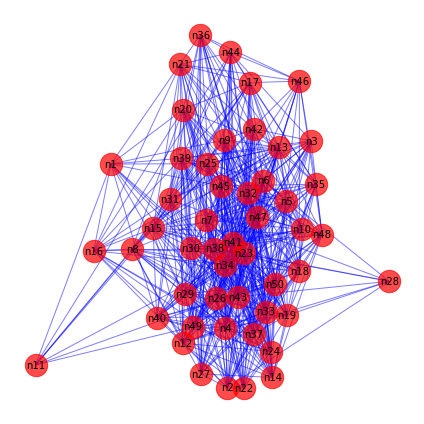

In [9]:
pos = nx.spring_layout(G)

# nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='red', alpha=0.7)

# edges
nx.draw_networkx_edges(G, pos, width=1, alpha=0.5, edge_color="b", style="-")

# labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

## 4-Defining Rules to Connecting Nodes and Adjusting `Probabilities/Distances`

* This would be the step that our Naive graph would evolve over the time through a simulation process

### `Example 1`: Add new connections

In [10]:
G.add_edge('n1', 'n5', weight=random.random())
G.add_edge('n1', 'n25', weight=random.random())

### `Example 2`: Remove an existing connection

In [11]:
existing_edges = list(G.edges)[0]
print (f'We remove edge {existing_edges[0]}-{existing_edges[1]}')
G.remove_edge(existing_edges[0], existing_edges[1])

We remove edge n1-n16


### `Example 3`: Update weight of an existing connection

In [12]:
existing_edges = list(G.edges)[-1]
print (f'We update weight of edge {existing_edges[0]}-{existing_edges[1]}')
G.remove_edge(existing_edges[0], existing_edges[1])
G.add_edge(existing_edges[0], existing_edges[1], weight=random.random())

We update weight of edge n18-n27


### Visualize the graph after the updates

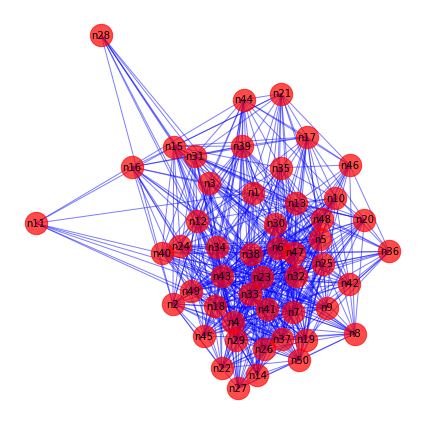

In [13]:
pos = nx.spring_layout(G)

# nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='red', alpha=0.7)

# edges
nx.draw_networkx_edges(G, pos, width=1, alpha=0.5, edge_color="b", style="-")

# labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()